In [10]:
from __future__ import division, print_function

In [11]:
%load_ext autoreload
%autoreload 2
%pylab inline
# %load_ext wurlitzer


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['box', 'interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
import time
import numpy as np
from collections import namedtuple


from director import viewerclient as vc
from irispy import Polyhedron
import boxatlas.boxatlas as box
from boxatlas.contactstabilization import BoxAtlasContactStabilization

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [13]:
vis = vc.Visualizer()

In [14]:
surfaces = [
    box.Surface(Polyhedron.fromBounds([1.2, 0], [1.2, 2]),
            Polyhedron(np.array([[1, -1], [1, 1]]), np.array([0, 0]))),
    box.Surface(Polyhedron.fromBounds([-2, 0], [2, 0]), 
            Polyhedron(np.array([[-2, -1], [2, -1]]), np.array([0, 0]))),
    box.Surface(Polyhedron.fromBounds([-2, 0], [2, 0]), 
            Polyhedron(np.array([[-2, -1], [2, -1]]), np.array([0, 0]))),
    box.Surface(Polyhedron.fromBounds([-1.2, 0], [-1.2, 2]),
            Polyhedron(np.array([[-1, -1], [-1, 1]]), np.array([0, 0]))),
]

limb_idx_map = dict()
limb_idx_map["right_arm"] = 0
limb_idx_map["right_leg"] = 1
limb_idx_map["left_leg"] = 2
limb_idx_map["left_arm"] = 3

limb_velocity_limits = [
        10,
        10,
        10,
        10
    ]

env = box.Environment(surfaces, Polyhedron.fromBounds([-1.2, 0], [1.2, 2]))
atlas = box.BoxAtlas()
atlas.limb_velocity_limits = limb_velocity_limits

def solveContactStabilization(initial_state):
    opt = BoxAtlasContactStabilization(initial_state, env)
    solnData = opt.solve()
    return solnData

# def drawSinglePlanFrame(vis, solnData, t):
#     states = solnData.states
#     inputs = solnData.inputs
#     ts = solnData.ts
#     box.draw(vis, states(t), inputs(t), env)

# def planPlayback(vis, solnData):
#     # unpack solution
#     states = solnData.states
#     inputs = solnData.inputs
#     ts = solnData.ts
    
#     # draw solution plan
#     for t in np.linspace(0, ts[-1] - 0.001, ts[-1] / 0.01):
#         drawSinglePlanFrame(solnData,t)
#         time.sleep(0.05)
        
# def planPlaybacSliderk(vis, solnData):
#     ts = solnData.ts
#     slider = widgets.FloatSlider(min=ts[0],max=ts[-1]-0.001,step=0.01,value=0)
#     interact(drawSinglePlanFrame, t=slider, solnData=fixed(solnData))
    
        
def makeDefaultInitialState():
    initial_state = box.BoxAtlasState(atlas)
    initial_state.qcom = np.array([0, 1])
    initial_state.vcom = np.array([-0, 0.])
    initial_state.qlimb = map(np.array, [[0.75, 1], [0.25, 0], [-0.25, 0], [-0.75, 1]])
    return initial_state

def testInitialVCOM(vcom_x_list):
    solnDataList = []
    
    for vcom_x in vcom_x_list:
        initial_state = makeDefaultInitialState()
        initial_state.vcom = np.array([vcom_x, 0])
        solnDataList.append(solveContactStabilization(initial_state))
        
    return solnDataList

def getContactIndicatorVariable(solnData, contact_name="left_arm"):
    idx = limb_idx_map[contact_name]
    ts = solnData.ts
    return [solnData.contact_indicator[idx](t) for t in ts[:-1]]
    

In [15]:
# solve a single problem and visualize the solution
initial_state = box.BoxAtlasState(atlas)
initial_state.qcom = np.array([0, 1])
initial_state.vcom = np.array([-4, 0.])
initial_state.qlimb = map(np.array, [[0.75, 1], [0.25, 0], [-0.25, 0], [-0.75, 1]])

solnData = solveContactStabilization(initial_state)
# visualizeContactStabilizationPlan(solnData)
box.planPlayback(vis, solnData, slider=True)

In [16]:
# Solve a sequence of problems for different initial velocities
vcom_x_list = np.arange(-1.0,-4, -0.25)
solnDataList = testInitialVCOM(vcom_x_list)

SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound


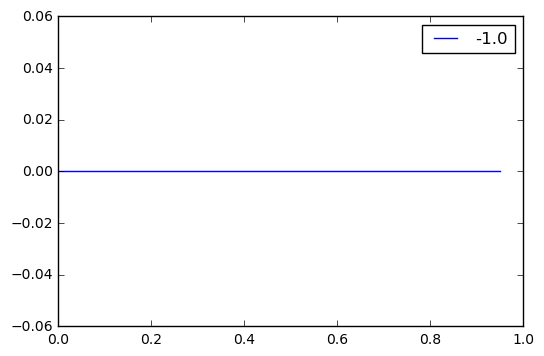

<function __main__.plotContactIndicator>

In [17]:
def plotContactIndicator(idx, solnDataList=solnDataList):
    solnData = solnDataList[idx]
    contact_indicator_left_arm = getContactIndicatorVariable(solnData, contact_name="left_arm")
    ts = solnData.ts
    vcom_x = solnData.states(0).vcom[0]
    label = str(vcom_x)
    plt.plot(ts[:-1], contact_indicator_left_arm, label=label, alpha=1.0)
    plt.legend(loc='best')
    plt.show()
    
slider = widgets.IntSlider(min=0,max=len(solnDataList)-1,step=1,value=0)
interact(plotContactIndicator, idx=slider, solnDataList=fixed(solnDataList))

In [ ]:
solnData = solnDataList[3]
vcom_x = solnData.states(0).vcom[0]
print("com initial x velocity = ", vcom_x)
visualizeContactStabilizationPlan(solnData)

In [ ]:
contact = solnData.opt.vars.contact[0]
t = 0.4
contact(t)[0]

In [ ]:
a = {'a':1}
type(a)

In [ ]:
solnData.opt.env